Version 2024-01-10, Arvid Lundervold

# Lab 2 Deep Learning - Simple MNIST NN from scratch (+ PyTorch)

In this notebook (modified from [Samson Zhang](https://github.com/wwsalmon): [[link](https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook)]), a simple two-layer neural network is implemented and trained on the MNIST digit 
recognizer dataset [[link](https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv)].<br> It's meant to be an instructional example, through which one can understand the underlying math of neural networks better.

( A video by Samson Zhang explaining all the math and showing the progress as he coded the network is here: https://youtu.be/w8yWXqWQYmU )

<img src="assets/MNIST-fig.png" width=720>

## A classification task: $y \approx f(\mathbf{X}, \theta)$


where $\mathbf{X}$ is the input data, $\theta$ are the parameters of the model, and $y$ is the output.

In [1]:
# Choices for the display of locally downloaded videos or stills      
DISPLAY_VIDEO = False

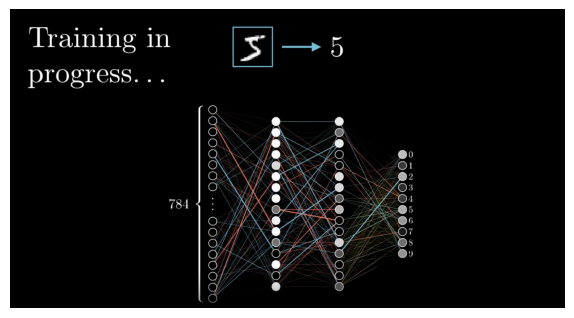

In [2]:
import os
from IPython.display import Video
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PPSV 

# Create a YouTube video instance
#video = YouTubeVideo("Ilg3gGewQ5U")
# Display the video in the notebook (requires an internet connection)
#display(video)


if DISPLAY_VIDEO:
  # Path to your local video file in the assets folder
  video_path = "assets/What-is-backpropagation-really-doing.mp4"  # Downloaded from YouTube using 4K Video Downloader+.app

  # Create a Video instance and display it
  display(Video(video_path, embed=True, width=720, height=480))  # You can adjust the width and height
else:
  # Load the image
  img = mpimg.imread('assets/What-is-backpropagation-really-doing-training-in-progess.png')

  # Set the figure size to achieve a width of 720 pixels
  dpi = plt.rcParams['figure.dpi']
  fig_width = 720 / dpi

  # Create a figure with the desired size
  plt.figure(figsize=(fig_width, fig_width * (img.shape[0] / img.shape[1])))

  # Display the image
  plt.imshow(img)
  plt.axis('off')  # Turn off axis numbers and labels
  plt.show()   
  

In [3]:
file_path = 'data/train.csv'
file_size = os.path.getsize(file_path)

print(f'The size of the file "{file_path}" is {file_size} bytes ({int(file_size/(1024**2))} Mb).')
# !ls -alh data/train.csv

The size of the file "data/train.csv" is 76775041 bytes (73 Mb).


<img src="assets/MNIST-data-matrix.png" width=720>

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load data obtained from https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv
data = pd.read_csv('data/train.csv')
print(f'# Instances: {len(data)} ; Columns: {data.columns[0]}, {data.columns[1]}, ..., {data.columns[-1]} ; Pixel values: min={data.min().min()}, max={data.max().max()}')


# Instances: 42000 ; Columns: label, pixel0, ..., pixel783 ; Pixel values: min=0, max=255


This Python code is importing necessary libraries and loading a dataset from a CSV file. Here's a breakdown of what each line does:

1. `import numpy as np`: This line imports the numpy library, which provides support for large, multi-dimensional arrays and matrices, along with a large collection of mathematical functions to operate on these arrays.

2. `import pandas as pd`: This line imports the pandas library, which provides data structures and data analysis tools for Python.

3. `from matplotlib import pyplot as plt`: This line imports the pyplot module from the matplotlib library, which provides a MATLAB-like plotting framework.

5. `data = pd.read_csv('data/train.csv')`: This line reads the CSV file located at 'data/train.csv' into a pandas DataFrame. The DataFrame is a two-dimensional labeled data structure with columns of potentially different types. It is generally the most commonly used pandas object.

6. `print(f'Columns: {data.columns[0]}, {data.columns[1]}, ..., {data.columns[-1]} ; Pixel values: min={data.min().min()}, max={data.max().max()}')`: This line prints the first two and the last column names of the DataFrame, as well as the minimum and maximum pixel values in the DataFrame. This is useful to quickly check the structure of the DataFrame and the range of pixel values it contains.


In [5]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T  # 1000 instances for dev set (2.38% of total)
y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

This Python code is part of a script for preparing a dataset for a machine learning task, specifically for training a neural network. Here's a breakdown of what each line does:

1. `data = np.array(data)`: This line converts the `data` into a numpy array. Numpy arrays are more efficient and provide more functionality for numerical operations than regular Python lists.

2. `m, n = data.shape`: This line gets the shape of the data array. `m` is the number of rows (samples) and `n` is the number of columns (features).

3. `np.random.shuffle(data)`: This line shuffles the rows of the data array. This is done to ensure that the training and development (dev) sets are random and representative of the overall distribution.

4. `data_dev = data[0:1000].T`: This line selects the first 1000 samples from the shuffled data array and transposes it for the development set.

5. `y_dev = data_dev[0]`: This line selects the first row of the development set as the target values (`y_dev`).

6. `X_dev = data_dev[1:n]`: This line selects the rest of the rows as the input features (`X_dev`) for the development set.

7. `X_dev = X_dev / 255.`: This line normalizes the input features of the development set by dividing each feature by 255. This is a common practice when working with image data, which is typically represented as 8-bit integers ranging from 0 to 255.

8-12. The lines of code for `data_train`, `y_train`, and `X_train` do the same thing as the lines of code for `data_dev`, `y_dev`, and `X_dev`, but for the training set instead of the development set.

13. `_,m_train = X_train.shape`: This line gets the shape of the training set. The underscore `_` is a common convention in Python for a variable that is being deliberately ignored. Here, it's used to ignore the number of features, since only the number of training samples `m_train` is needed.

In [6]:
print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}, m_train = {m_train}, Y_train labels: {y_train}')

X_train.shape = (784, 41000), y_train.shape = (41000,), m_train = 41000, Y_train labels: [1 4 3 ... 2 4 7]


Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

The provided mathematical framework describes the operation of a neural network (NN) with two layers, designed for image classification. Here's an explanation of each part:

### Neural Network Architecture
1. **Input Layer ($a^{[0]}$)**: Represents each pixel in a 28x28 input image, totaling 784 units. These units serve as the initial input data for the network.
2. **Hidden Layer ($a^{[1]}$)**: Consists of 10 units using the ReLU (Rectified Linear Unit) activation function. ReLU is chosen for its ability to handle non-linearity and for being computationally efficient.
3. **Output Layer ($a^{[2]}$)**: Comprises 10 units corresponding to the ten digit classes (0-9). It uses the softmax activation function, which is suitable for multi-class classification tasks.

### Forward Propagation
This process involves calculating the output from the network for a given input.
1. **Calculation of $Z^{[1]}$**: Multiplies the weights $W^{[1]}$ with the input $X$ and adds the bias $b^{[1]}$.
2. **Activation with ReLU ($A^{[1]}$)**: Applies the ReLU activation function to $Z^{[1]}$.
3. **Calculation of $Z^{[2]}$**: Similar to $Z^{[1]}$, but using the output of the first layer ($A^{[1]}$) as input.
4. **Activation with Softmax ($A^{[2]}$)**: Applies the softmax activation to $Z^{[2]}$, resulting in the final output of the network.

### Backward Propagation
This process involves adjusting the network's weights and biases based on the error in its output.
1. **Calculation of $dZ^{[2]}$**: The difference between the network's output ($A^{[2]}$) and the true labels ($Y$).
2. **Calculation of $dW^{[2]}$ and $dB^{[2]}$**: Computes the gradients of the weights and biases for the second layer.
3. **Calculation of $dZ^{[1]}$**: Calculates the gradient of the loss with respect to $Z^{[1]}$, considering the derivative of the ReLU function.
4. **Calculation of $dW^{[1]}$ and $dB^{[1]}$**: Similar to the second layer, but for the first layer.

### Parameter Updates
This step updates the weights and biases using the gradients calculated in backpropagation, scaled by a learning rate ($\alpha$).

### Variables and Shapes
- For each layer and parameter, the shape is defined to ensure proper matrix operations. For instance, $W^{[1]}$ is a 10x784 matrix, allowing it to be multiplied with the $ 784 \times m$ input $X$.

Understanding these components and their interplay is crucial for grasping how neural networks learn from data and make predictions. This network, in particular, is structured to process image data and classify it into one of several categories, a common task in machine learning.

### Explanation:

1. **Model Class**: Defined as `SimpleNN`, this class inherits from `nn.Module`. It includes a flattening layer, a hidden layer with 10 units, and an output layer with 10 units. The forward method defines the sequence of operations for forward propagation.

2. **Loss Function and Optimizer**: The CrossEntropyLoss is used, which is common for classification tasks. The Adam optimizer is chosen for updating the weights.

3. **Dummy Dataset**: We create a random dataset to simulate the training process. In practice, you would use a real dataset like MNIST.

4. **Training Loop**: The loop involves zeroing the gradient buffers (`optimizer.zero_grad()`), performing a forward pass, calculating the loss, performing backpropagation (`loss.backward()`), and updating the weights (`optimizer.step()`).

5. **Model Summary**: The final print statement displays the architecture of the model.

This code snippet provides a basic setup for a two-layer neural network in PyTorch, covering both the architecture and the training process. In a real-world application, additional steps such as data preprocessing, validation, and testing would be necessary.

In [7]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

This Python code is implementing a simple neural network from scratch using numpy. Here's a breakdown of what each function does:

1. `init_params()`: This function initializes the weights `W1` and `W2` and biases `b1` and `b2` for a two-layer neural network. The weights are initialized as random numbers between -0.5 and 0.5.

2. `ReLU(Z)`: This function applies the Rectified Linear Unit (ReLU) activation function to the input `Z`. The ReLU function returns `Z` when `Z > 0` and `0` otherwise.

3. `softmax(Z)`: This function applies the softmax activation function to the input `Z`. The softmax function is often used in the output layer of a neural network for multi-class classification problems. It transforms the input into a probability distribution over the classes.

4. `forward_prop(W1, b1, W2, b2, X)`: This function performs forward propagation through the network. It calculates the linear and activation outputs `Z1`, `A1`, `Z2`, `A2` for each layer.

5. `ReLU_deriv(Z)`: This function calculates the derivative of the ReLU function. This is used during backpropagation to calculate the gradients.

6. `one_hot(Y)`: This function converts the labels `Y` into a one-hot encoded format. One-hot encoding is a representation method that converts the categorical data into a format that works better with classification and regression algorithms.

7. `backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)`: This function performs backward propagation through the network. It calculates the gradients of the loss function with respect to the weights and biases.

8. `update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)`: This function updates the weights and biases using the gradients calculated during backpropagation and the learning rate `alpha`.

The cursor is on line 7, which is part of the `softmax(Z)` function. This line calculates the softmax of `Z` by taking the exponential of `Z` and dividing it by the sum of the exponentials of `Z`. This transforms `Z` into a probability distribution.

In [8]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.round(np.sum(predictions == Y) / Y.size, 3)

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 25 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, Y)}')
    return W1, b1, W2, b2

This Python code defines several functions that are used to train a simple neural network and evaluate its performance. Here's a breakdown of what each function does:

1. `get_predictions(A2)`: This function takes the output of the last layer of the neural network (`A2`) and returns the indices of the maximum values along axis 0 (which usually represents different samples). In the context of a classification task, this means it's returning the classes with the highest predicted probabilities.

2. `get_accuracy(predictions, Y)`: This function calculates the accuracy of the predictions. It first prints the predictions and the true labels `Y`, then it calculates the accuracy as the proportion of predictions that exactly match the true labels.

3. `gradient_descent(X, Y, alpha, iterations)`: This function implements the gradient descent algorithm for optimizing the neural network's parameters. It first initializes the parameters (`W1`, `b1`, `W2`, `b2`), then it enters a loop that runs for a specified number of iterations. In each iteration, it performs forward propagation to calculate the network's output, performs backward propagation to calculate the gradients of the loss with respect to the parameters, and then updates the parameters using these gradients. Every 10 iterations, it prints the current iteration number and the accuracy of the network's predictions on the data.

The cursor is on line 4, which is part of the `get_accuracy(predictions, Y)` function. This line calculates the accuracy of the predictions by comparing them to the true labels `Y`. The `==` operator performs element-wise comparison and returns a boolean array, which is then summed and divided by the total number of labels to get the proportion of correct predictions.

The following Python code is running the `gradient_descent` function to train a simple neural network on a training dataset (`X_train`, `Y_train`). Here's a breakdown of what each line does:

1. `%%time`: This is a magic command in Jupyter Notebook that times the execution of the specific cell. It will output the time taken to run the cell once it completes.

2. `W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)`: This line is calling the `gradient_descent` function with the training data, a learning rate of `0.10`, and `500` iterations. The function returns the optimized weights and biases (`W1`, `b1`, `W2`, `b2`) of the neural network after training. These parameters can then be used to make predictions on new data.

The cursor is on line 1, which is the `%%time` magic command. This command is used to time the execution of the cell in a Jupyter Notebook.

In [9]:
%%time
W1, b1, W2, b2 = gradient_descent(X_train, y_train, 0.10, 500)

Iteration:  0
[3 9 7 ... 9 4 4] [1 4 3 ... 2 4 7]
Accuracy: 0.082
Iteration:  25
[1 0 0 ... 2 4 7] [1 4 3 ... 2 4 7]
Accuracy: 0.282
Iteration:  50
[1 0 2 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.44
Iteration:  75
[1 4 2 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.546
Iteration:  100
[1 4 2 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.611
Iteration:  125
[1 4 2 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.659
Iteration:  150
[1 4 2 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.692
Iteration:  175
[1 4 3 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.717
Iteration:  200
[1 4 3 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.738
Iteration:  225
[1 4 3 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.754
Iteration:  250
[1 4 3 ... 2 9 7] [1 4 3 ... 2 4 7]
Accuracy: 0.768
Iteration:  275
[1 4 3 ... 2 4 7] [1 4 3 ... 2 4 7]
Accuracy: 0.78
Iteration:  300
[1 4 3 ... 2 4 7] [1 4 3 ... 2 4 7]
Accuracy: 0.79
Iteration:  325
[1 4 3 ... 2 4 7] [1 4 3 ... 2 4 7]
Accuracy: 0.8
Iteration:  350
[1 4 3 ... 2 4 7] [1 4 3 ... 2 4 7]
Accura

~84% accuracy on the training set.

In [10]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

This Python code defines two functions that are used to make predictions with the trained neural network and to test a single prediction. Here's a breakdown of what each function does:

1. `make_predictions(X, W1, b1, W2, b2)`: This function performs forward propagation on the input `X` using the provided weights and biases (`W1`, `b1`, `W2`, `b2`), gets the predictions by calling the `get_predictions` function on the output of the last layer, and returns these predictions.

2. `test_prediction(index, W1, b1, W2, b2)`: This function tests the neural network's prediction on a single sample from the training set. It gets the current image and its label, makes a prediction using the `make_predictions` function, and prints the prediction and the label. It then reshapes the current image into a 28x28 array (since the images in the MNIST dataset are 28x28 pixels), multiplies it by 255 to undo the normalization, and displays the image using matplotlib's `imshow` function.

The cursor is on line 2, which is part of the `make_predictions` function. This line performs forward propagation on the input `X` using the provided weights and biases, and stores the output of the last layer in `A2`.

Let's look at a couple of examples:

Prediction:  [1]
Label:  1


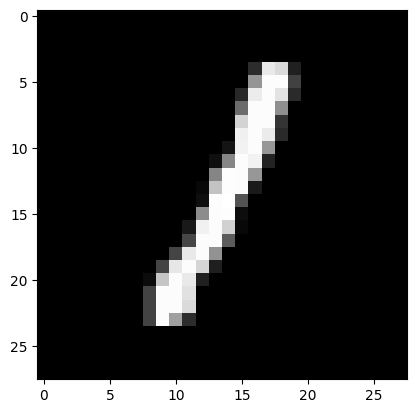

Prediction:  [4]
Label:  4


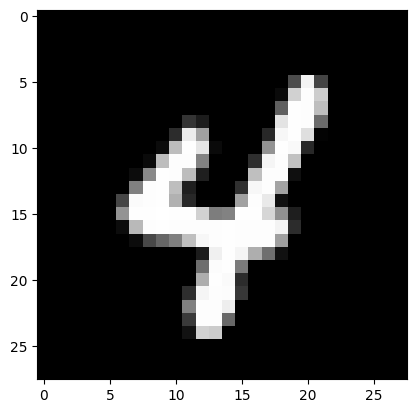

Prediction:  [3]
Label:  3


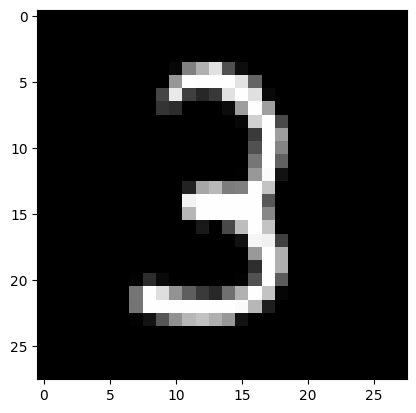

Prediction:  [8]
Label:  8


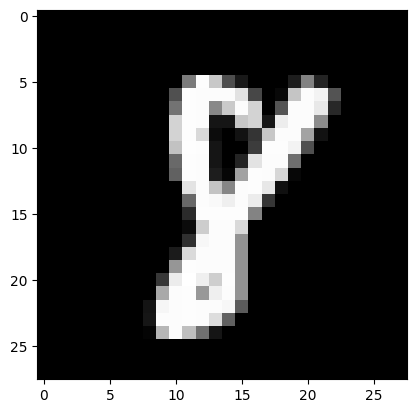

CPU times: user 795 ms, sys: 292 ms, total: 1.09 s
Wall time: 390 ms


In [11]:
%%time
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

This Python code is testing the trained neural network's predictions on the first four samples from the training set. Here's a breakdown of what each line does:

1. `%%time`: This is a magic command in Jupyter Notebook that times the execution of the specific cell. It will output the time taken to run the cell once it completes.

2-5. `test_prediction(0, W1, b1, W2, b2)`, `test_prediction(1, W1, b1, W2, b2)`, `test_prediction(2, W1, b1, W2, b2)`, `test_prediction(3, W1, b1, W2, b2)`: These lines are calling the `test_prediction` function with the indices of the samples to test (0, 1, 2, and 3) and the trained weights and biases (`W1`, `b1`, `W2`, `b2`). The function will print the neural network's prediction and the true label for each sample, and display the corresponding image.

The cursor is on line 0, which is the `%%time` magic command. This command is used to time the execution of the cell in a Jupyter Notebook.

Finally, let's find the accuracy on the dev set:

In [12]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, y_dev)

[9 7 4 6 6 6 7 1 7 0 5 4 2 4 7 1 3 2 9 8 2 5 1 4 5 4 6 6 3 6 7 3 4 7 4 6 5
 9 3 3 4 3 3 7 2 3 8 2 4 6 7 0 9 4 3 7 8 8 1 9 7 8 2 8 7 0 5 2 2 6 1 4 3 7
 9 1 4 4 3 3 4 3 5 5 8 8 2 4 7 3 7 2 0 9 8 0 7 4 7 4 8 1 9 8 4 3 9 3 2 6 4
 9 1 5 6 5 1 3 6 1 4 6 5 1 2 8 0 5 2 1 1 5 8 8 2 0 6 8 5 1 7 0 5 0 9 1 2 3
 1 5 2 0 2 3 1 7 1 3 9 3 7 7 9 1 5 9 0 5 0 8 4 7 4 4 6 1 2 8 6 6 0 6 5 3 8
 0 7 4 1 0 1 2 7 9 6 9 5 9 7 2 4 9 4 7 6 2 2 2 8 9 4 7 8 9 4 6 1 0 4 3 7 2
 8 0 5 0 1 7 1 6 2 6 0 2 9 2 1 1 1 3 3 2 4 0 8 4 6 8 6 5 0 8 2 0 5 3 2 3 6
 9 9 6 9 3 7 3 7 1 9 8 5 6 1 8 0 4 8 4 0 5 9 7 6 3 7 9 9 0 8 1 8 4 1 1 4 4
 5 4 0 4 6 4 7 2 6 5 7 8 4 3 3 2 0 4 2 9 1 8 5 4 9 4 6 6 0 5 1 8 5 3 0 6 4
 3 4 0 7 5 1 0 1 0 1 3 0 6 9 5 3 2 9 6 7 4 0 5 1 4 1 2 4 7 9 9 4 1 7 7 6 1
 9 9 6 3 6 6 8 1 0 1 3 5 0 0 6 3 3 0 7 3 3 7 1 7 0 5 7 8 8 5 5 0 4 6 3 6 0
 6 7 6 5 2 3 8 5 4 8 7 1 7 6 9 9 7 7 8 9 1 3 6 8 5 0 2 7 6 4 8 0 6 4 9 0 4
 8 9 9 1 3 9 0 7 4 2 4 2 7 8 5 5 0 9 0 7 5 2 0 2 7 0 4 8 1 7 3 9 8 3 8 1 0
 9 9 8 2 1 4 4 6 3 3 5 8 

0.83

This Python code is making predictions on the development set using the trained neural network and then calculating the accuracy of these predictions. Here's a breakdown of what each line does:

1. `dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)`: This line is calling the `make_predictions` function with the development set `X_dev` and the trained weights and biases (`W1`, `b1`, `W2`, `b2`). The function performs forward propagation on `X_dev` using the provided weights and biases, gets the predictions by calling the `get_predictions` function on the output of the last layer, and returns these predictions.

2. `get_accuracy(dev_predictions, Y_dev)`: This line is calling the `get_accuracy` function with the predictions on the development set and the true labels `Y_dev`. The function calculates the accuracy as the proportion of predictions that exactly match the true labels, and prints this accuracy.

The cursor is on line 1, which is the call to the `make_predictions` function. This function is used to make predictions with the trained neural network on the development set.

Still ~84% accuracy, so our model generalized from the training data pretty well.

## A PyTorch implementation with one hidden layers
Creating a similar neural network using PyTorch involves defining the model architecture, specifying the forward propagation steps, and setting up the training loop, which includes both forward and backward propagation. Let's dive into the PyTorch implementation:

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(784, 10)  # First layer (input to hidden)
        self.dense2 = nn.Linear(10, 10)   # Second layer (hidden to output)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.dense1(x))  # ReLU activation for hidden layer
        x = self.dense2(x)          # No activation yet for output layer
        return x

# Create the model
model = SimpleNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy dataset
# num_samples = 1000
# X_train = torch.rand(num_samples, 1, 28, 28)  # Simulating 28x28 grayscale images in MNIST
# y_train = torch.randint(0, 10, (num_samples,))  # Random labels for 10 classes

# Real dataset - in our case from the MNIST database, and convert it to proper tensors
X_train_reshape = X_train.T.reshape(-1, 1, 28, 28)  # Reshape to: num_samples, 1 batch size, flattened 28x28 grayscale images
X_train_torch = torch.from_numpy(X_train_reshape).float()
print(f'X_train_torch.shape = {X_train_torch.shape}')

y_train_torch = torch.from_numpy(y_train).long()
print(f'y_train_torch.shape = {y_train_torch.shape}')

# Create data loader
bs = 64 # Batch size
train_data = TensorDataset(X_train_torch, y_train_torch) 
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()             # Zero the gradient buffers
        outputs = model(inputs)           # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward()                   # Backward pass
        optimizer.step()                  # Update weights

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


# Print the model architecture
print(f'\nModel architecture: {model}')



X_train_torch.shape = torch.Size([41000, 1, 28, 28])
y_train_torch.shape = torch.Size([41000])
Epoch 1, Loss: 0.33551618456840515
Epoch 2, Loss: 0.34752604365348816
Epoch 3, Loss: 0.1113719567656517
Epoch 4, Loss: 0.21799728274345398
Epoch 5, Loss: 0.31391769647598267
Epoch 6, Loss: 0.15237930417060852
Epoch 7, Loss: 0.23328611254692078
Epoch 8, Loss: 0.4528135657310486
Epoch 9, Loss: 0.14703989028930664
Epoch 10, Loss: 0.553990364074707

Model architecture: SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=784, out_features=10, bias=True)
  (dense2): Linear(in_features=10, out_features=10, bias=True)
)


This Python script is implementing a simple neural network for a classification task using PyTorch. Here's a breakdown of what each part does:

1. **Import necessary libraries**: The script starts by importing the necessary PyTorch modules.

2. **Define the neural network architecture**: A simple neural network is defined using the `nn.Module` class from PyTorch. This network has an input layer (`self.dense1`), a hidden layer with ReLU activation function (`F.relu(self.dense1(x))`), and an output layer (`self.dense2`).

3. **Create the model**: An instance of the `SimpleNN` class is created. This instance, `model`, is the neural network that will be trained.

4. **Define the loss function and optimizer**: The script uses cross-entropy loss (`nn.CrossEntropyLoss()`) as the loss function and the Adam optimizer (`optim.Adam()`) for training the neural network.

5. **Prepare the data**: The script reshapes the training data (`X_train`) to match the input shape expected by the neural network and converts it to a PyTorch tensor. It also converts the training labels (`y_train`) to a PyTorch tensor. These tensors are then used to create a `TensorDataset`, which is a dataset wrapping tensors. A `DataLoader` is created for the `TensorDataset` to handle batching of the data.

6. **Train the model**: The script then enters a training loop. For each epoch, it iterates over the `DataLoader`, performing a forward pass, calculating the loss, performing a backward pass, and updating the weights of the neural network.

7. **Print the model architecture**: Finally, the script prints the architecture of the model.


###  Make predictions with the trained one-hidden layer PyTorch model

To make predictions on an unseen dataset and report performance metrics, you'll need to:

1. Load the unseen dataset (i.e. the X_dev and y_dev arrays). They are reprocessed in the same way as the training data.
3. Pass the data through the model to get predictions.
4. Compare the predictions with the true labels to calculate performance metrics.

Here's how you can do it:

In [14]:
# Real unseen (_dev) dataset - in our case from the MNIST database, and convert it to proper tensors
X_test_reshape = X_dev.T.reshape(-1, 1, 28, 28)  # Reshape to: num_samples, 1 batch size, flattened 28x28 grayscale images
X_test_torch = torch.from_numpy(X_test_reshape).float()
print(f'X_test_torch.shape = {X_test_torch.shape}')

y_test_torch = torch.from_numpy(y_dev).long()
print(f'y_test_torch.shape = {y_test_torch.shape}')

X_test_torch.shape = torch.Size([1000, 1, 28, 28])
y_test_torch.shape = torch.Size([1000])


This Python code is preparing the unseen test dataset (also known as the development or "_dev" dataset) for evaluation with a PyTorch model. Here's a breakdown of what each line does:

1. `X_test_reshape = X_dev.T.reshape(-1, 1, 28, 28)`: This line reshapes the test data `X_dev` into a format that can be used with the PyTorch model. The `-1` in the reshape function means that this dimension will be determined based on the size of the other dimensions, so the resulting shape will be `(num_samples, 1, 28, 28)`. This is the shape expected by the PyTorch model: `num_samples` samples, each with 1 channel (because the images are grayscale), and each image is 28x28 pixels.

2. `X_test_torch = torch.from_numpy(X_test_reshape).float()`: This line converts the reshaped test data into a PyTorch tensor of type float.

3. `print(f'X_test_torch.shape = {X_test_torch.shape}')`: This line prints the shape of the test data tensor. This is useful for debugging and ensuring that the data is in the correct format.

4. `y_test_torch = torch.from_numpy(y_dev).long()`: This line converts the test labels `y_dev` into a PyTorch tensor of type long. The PyTorch model expects the labels to be in this format.

5. `print(f'y_test_torch.shape = {y_test_torch.shape}')`: This line prints the shape of the test labels tensor. This is useful for debugging and ensuring that the labels are in the correct format.


In [15]:
%%time 

from sklearn.metrics import classification_report
import torch

# Load the unseen dataset
#dev_data = pd.read_csv('data/dev.csv')

# Preprocess the data
#X_dev = dev_data.drop('label', axis=1).values / 255
#y_dev = dev_data['label'].values
#X_dev_torch = torch.from_numpy(X_dev).float()
#y_dev_torch = torch.from_numpy(y_dev).long()

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Temporarily turn off gradient descent
    outputs = model(X_test_torch)
    _, predicted = torch.max(outputs, 1)

# Calculate performance metrics
print(classification_report(y_test_torch, predicted))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        96
           1       0.94      0.98      0.96       107
           2       0.85      0.87      0.86        86
           3       0.90      0.89      0.89       107
           4       0.92      0.92      0.92       100
           5       0.87      0.93      0.90        99
           6       0.93      0.95      0.94       102
           7       0.94      0.85      0.89       114
           8       0.90      0.83      0.87       108
           9       0.85      0.88      0.86        81

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.91      0.91      0.91      1000

CPU times: user 847 ms, sys: 488 ms, total: 1.33 s
Wall time: 822 ms




This script uses the `classification_report` function from `sklearn.metrics` to calculate and print several performance metrics, including precision, recall, f1-score, and support for each class, as well as the overall accuracy of the model.

Please note that this script assumes that your dev dataset is in the same format as your training dataset and that it's located at 'data/dev.csv'. If this is not the case, you'll need to adjust the script accordingly.



In this example, `model` is an instance of the `Net` class, which is a simple feed-forward neural network with one hidden layer. The `forward` method defines the forward pass of the network.

In your provided code, `model.eval()` is used to set the model to evaluation mode. This turns off features like dropout and batch normalization that are used during training but not during evaluation.

Then, `outputs = model(X_test_torch)` is used to make predictions on the test data. The model's forward pass is called with the test data as input, and it returns the raw, unnormalized scores (also known as logits) for each class.

Finally, `_, predicted = torch.max(outputs, 1)` is used to get the predicted class indices. `torch.max()` returns the maximum value of all elements in the `outputs` tensor along the dimension 1 (which represents the class dimension), and its corresponding indices. The underscore `_` is a conventional variable used to store the maximum values, which are not needed in this case. The `predicted` tensor contains the predicted class indices.

## A PyTorch implementation with two hidden layers

Creating a PyTorch model for MNIST classification with the initially specified architecture (2 hiddel layers) involves several steps. The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0-9), which we flatten into a 784-dimensional input vector for feeding into a neural network. The network will have two hidden layers and a final output layer that uses one-hot encoding for the 10 possible classes (digits 0-9). Here's a step-by-step guide to the PyTorch code for this task:

Cf. multiple hidden layers in:

<img src="assets/Waldrop-multiple-hidden-layers.png" width=720>

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### 2. Define the Neural Network
Here's a class definition for the neural network. It includes an input layer, two hidden layers, and an output layer.

In [17]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 128) # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, 10)   # Output layer with 10 neurons (one for each class)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation function for first hidden layer
        x = F.relu(self.fc2(x))  # Activation function for second hidden layer
        x = self.fc3(x)          # No activation needed in the output layer
        return x

### 3. Load and Preprocess the MNIST Data
PyTorch provides a convenient way to load the MNIST dataset. We need to flatten the images for our network.

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

### 4. Instantiate the Model, Define Loss Function and Optimizer
Here, we create an instance of our model, select a loss function, and choose an optimizer.

In [19]:
model = MNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### 5. Train the Model
The training loop involves forwarding the input data through the model, calculating the loss, and adjusting the weights of the network accordingly.

In [20]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

### 6. Evaluate the Model
After training, we evaluate the model's performance on the test dataset.<br>
We also compute the **confusion matrix** and collect misclassified instances.

In [21]:


def test_and_collect_misclassified(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix_data = np.zeros((10, 10), dtype=int)
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_pred_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Update confusion matrix
            for t, p in zip(target.view_as(pred), pred):
                confusion_matrix_data[t.item(), p.item()] += 1

            # Collect misclassified images
            misclassified_indices = (pred != target.view_as(pred)).nonzero()[:, 0]
            for idx in misclassified_indices:
                misclassified_images.append(data[idx])
                misclassified_true_labels.append(target[idx])
                misclassified_pred_labels.append(pred[idx])

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')
    return confusion_matrix_data, misclassified_images, misclassified_true_labels, misclassified_pred_labels



#### 6b. Display the Confusion Matrix
After running the test, use the following function to display the confusion matrix.

In [22]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_title('Confusion Matrix')

    # Loop over data dimensions and create text annotations
    for i in range(10):
        for j in range(10):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2. else "black")
    
    plt.show()


#### 6c. Display Misclassified Instances
This function displays a grid of misclassified images.

In [23]:
def plot_misclassified_images(images, true_labels, pred_labels):
    plt.figure(figsize=(10, 10))
    for i, (img, true_label, pred_label) in enumerate(zip(images, true_labels, pred_labels)):
        plt.subplot(5, 5, i+1)
        plt.imshow(img.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_label.item()}, Pred: {pred_label.item()}', fontsize=8)
        plt.axis('off')
    plt.show()


### 7. Run the Training and Testing

Finally, we run the training and testing processes, and then display the confusion matrix and misclassified images.

Using device: cpu

Test set: Average loss: 0.0023, Accuracy: 1005/10000 (10%)



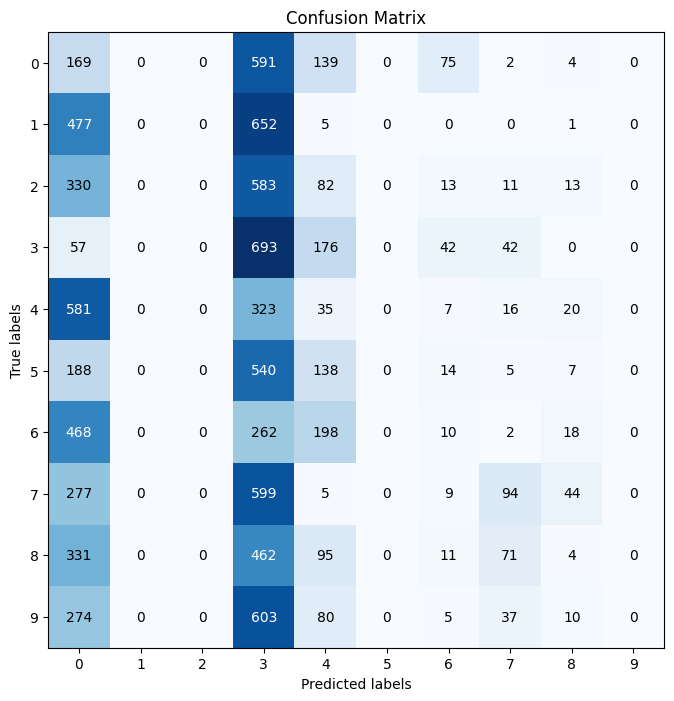

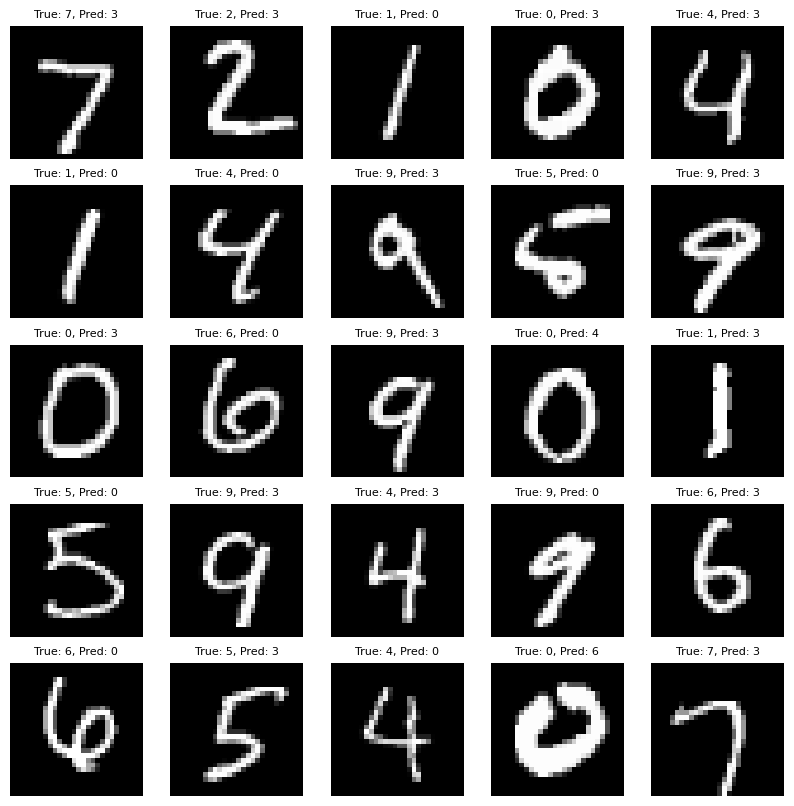

CPU times: user 2.67 s, sys: 512 ms, total: 3.18 s
Wall time: 2.29 s


In [24]:
%%time

# Check if CUDA is available and set PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

confusion_data, misclassified_imgs, true_lbls, pred_lbls = test_and_collect_misclassified(model, device, test_loader)

# Display confusion matrix
plot_confusion_matrix(confusion_data)

# Display some misclassified images
plot_misclassified_images(misclassified_imgs[:25], true_lbls[:25], pred_lbls[:25])


This code provides a basic structure for an MNIST classifier using PyTorch. 
It will also provide a visual understanding of your model's performance, showing where it gets confused and what kinds of mistakes it makes. This is particularly useful for fine-tuning and improving your model. You can modify the number of neurons in the hidden layers, the number of epochs, or other parameters to experiment with the network's performance.